In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeAthensV2

import pennylane as qml

import matplotlib.pyplot as plt

from random import shuffle
from tqdm import tqdm

In [2]:
import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import custom_ghz
from circuits.modify_circuits import append_pqc_to_quantum_circuit, get_circuit_for_model, get_unitary_for_model_pennylane
from circuits.pqc_circuits import pennylane_PQC_RZRXRZ_unique, qiskit_PQC_RZRXRZ_unique, qiskit_PQC_RXRZ_unique

from simulator.simulate import get_ideal_data_superpos
from models.pennylane_models import SimplePennyLaneQuantumModel
from models.noise_models import BitPhaseFlipNoise
from circuits.generate_circuits import GetGHZCircuitsForModel

In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    torch_device = torch.device("mps")
    aer_device = "CPU"
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    torch_device = torch.device("cuda")
    aer_device = "GPU"
else:
    print('Torch running on CPU')
    torch_device = torch.device("cpu")
    aer_device = "CPU"


Torch running on Nvidia GPU


In [5]:
NUM_SHOTS = 2**10
NUM_QUBITS = 5
H_ON = 2
INPUT_BITS = '10101'
EPOCHS = 5
# fakeVigo2_backend = FakeVigoV2()
# fakeAthensV2_backend = FakeAthensV2()

ideal_sim = AerSimulator()
# noisy_sim = AerSimulator().from_backend(fakeAthensV2_backend)
pqc_arch = pennylane_PQC_RZRXRZ_unique

In [6]:
class QuantumFidelityLoss(nn.Module):
    def __init__(self, num_shots=1024, is_counts=True, eps: float = 1e-8):
        super(QuantumFidelityLoss, self).__init__()
        self.num_counts = num_shots
        self.is_counts = is_counts
        self.eps = eps
    
    def forward(self, ideal:torch.Tensor, measured:torch.Tensor):
        """
        Classical fidelity  F(P,Q) = (Σ√(p_i q_i))²
        Loss  = 1 - F.
        Both inputs are 1-D tensors of equal length whose elements represent the "counts" of the measured state at their respective index. 
        """
        if self.is_counts:
            # --- smoothing & normalisation ---------------------------------
            p = ideal / self.num_counts + self.eps         # avoid √0 and log0 issues
            q = measured / self.num_counts + self.eps
            
            # print('Ideal: ', ideal)
            # print('p: ', p)
            # print('Measured: ', measured)
            # print('q: ', q)
            
            
            p = p / p.sum()
            q = q / q.sum()

        else:
            p = torch.clamp(ideal, min=1e-8)
            q = torch.clamp(measured, min=1e-8)

        # print(p.sum(), q.sum())

        # Over here, p.sum and q.sum should be 1.0


        fidelity = torch.square(torch.sum(torch.sqrt(p * q)))     # Bhattacharyya coefficient
        # fidelity = bc ** 2                    # square → classical fidelity
        return 1.0 - fidelity                 # minimise this

        

In [7]:
noise_model = BitPhaseFlipNoise()

pqc_model = SimplePennyLaneQuantumModel(
    num_qubits= NUM_QUBITS, num_params=NUM_QUBITS*3, pqc_arch_func=pqc_arch
    )

ghz_circuit_gen = GetGHZCircuitsForModel(
    num_qubits= NUM_QUBITS, hammard_on=H_ON, noise=noise_model
    )



In [8]:
optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.005)
# loss_fn = QuantumFidelityLoss(is_counts=False)
loss_fn = nn.MSELoss()

In [9]:
ideal_data = get_ideal_data_superpos(NUM_QUBITS, NUM_SHOTS, num_vals=int(1000), prob_dist=True)
# get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=1000, get_soft=False)
print(len(ideal_data[10][1]))

Generating Ideal Data: 100%|██████████| 1000/1000 [00:01<00:00, 647.38it/s]

32


In [10]:
param_list_epoch = []  # Stores parameter evolution across epochs
loss_list_epoch = []   # Stores mean loss per epoch

enable_debug_logs = True  # Set False to suppress grad/param printouts
lambda_reg = 0.01         # Regularization weight

for epoch in range(EPOCHS):
    print(f'\n Starting Epoch {epoch+1}')
    pqc_model.train()
    epoch_loss_list = []
    epoch_param_snapshots = []

    shuffle(ideal_data)
    data_iterator = tqdm(ideal_data)

    for step, (params, ideal) in enumerate(data_iterator):
        optimizer.zero_grad()

        circuit = ghz_circuit_gen.get_noisy_model_circuit_params(params)
        measured = pqc_model(circuit=circuit)

        ideal = ideal.float().to(torch_device)
        measured = measured.float().to(torch_device)

        # print(ideal)
        # print(measured)

        # Compute fidelity loss
        loss = loss_fn(ideal, measured)

        # Add optional regularization to keep angles from zeroing out

        loss.backward()
        optimizer.step()

        raw_param_values = pqc_model.raw_params.detach().cpu().numpy()
        epoch_param_snapshots.append(raw_param_values)
        epoch_loss_list.append(loss.item())

        data_iterator.set_postfix_str(f"Loss: {loss.item():.4e}")

        # Optional: print debug stats
        if enable_debug_logs and step == 0:
            grad_norm = pqc_model.raw_params.grad.norm().item()
            # bounded = pqc_model.raw_params.detach().cpu().numpy()
            print(f"\tStep {step}, grad norm: {grad_norm:.4e}")
            print(f"\tRaw param range: [{raw_param_values.min():.3f}, {raw_param_values.max():.3f}]")
            # print(f"\tBounded param range: [{bounded.min():.3f}, {bounded.max():.3f}]")

    # Log epoch summary
    avg_loss = np.mean(epoch_loss_list)
    loss_list_epoch.append(avg_loss)
    param_list_epoch.extend(np.array(epoch_param_snapshots))

    print(f"Epoch {epoch+1} complete: avg loss = {avg_loss:.4e}")

    


 Starting Epoch 1


  1%|          | 12/1000 [00:00<00:22, 44.18it/s, Loss: 8.5856e-03]

	Step 0, grad norm: 2.4669e-03
	Raw param range: [-3.674, 11.572]


100%|██████████| 1000/1000 [00:10<00:00, 91.22it/s, Loss: 6.3872e-04]


Epoch 1 complete: avg loss = 2.0833e-03

 Starting Epoch 2


  1%|          | 8/1000 [00:00<00:13, 74.62it/s, Loss: 1.4303e-04]

	Step 0, grad norm: 8.7153e-04
	Raw param range: [-3.494, 12.328]


100%|██████████| 1000/1000 [00:10<00:00, 91.84it/s, Loss: 2.8716e-04]


Epoch 2 complete: avg loss = 2.1301e-04

 Starting Epoch 3


  1%|          | 9/1000 [00:00<00:11, 89.42it/s, Loss: 3.2669e-04]

	Step 0, grad norm: 1.4349e-03
	Raw param range: [-3.324, 12.351]


100%|██████████| 1000/1000 [00:11<00:00, 86.63it/s, Loss: 2.6028e-04]


Epoch 3 complete: avg loss = 1.6807e-04

 Starting Epoch 4


  1%|          | 10/1000 [00:00<00:10, 96.52it/s, Loss: 8.9285e-05]

	Step 0, grad norm: 8.3341e-04
	Raw param range: [-3.371, 12.282]


100%|██████████| 1000/1000 [00:12<00:00, 79.83it/s, Loss: 1.5365e-04]


Epoch 4 complete: avg loss = 1.5101e-04

 Starting Epoch 5


  1%|          | 10/1000 [00:00<00:10, 94.16it/s, Loss: 1.4949e-04]

	Step 0, grad norm: 5.9395e-04
	Raw param range: [-3.353, 12.323]


100%|██████████| 1000/1000 [00:13<00:00, 71.78it/s, Loss: 2.3765e-04]

Epoch 5 complete: avg loss = 1.4695e-04


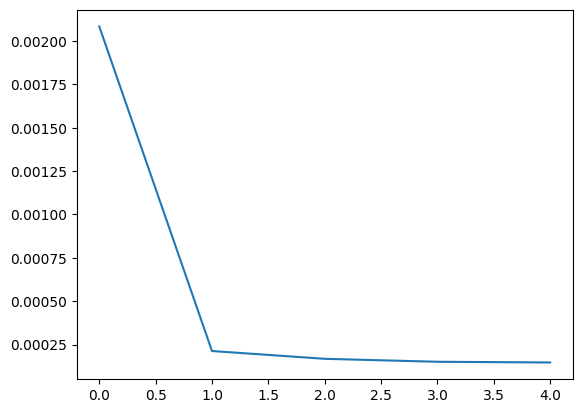

In [11]:
plt.plot(range(EPOCHS), loss_list_epoch)
plt.show()

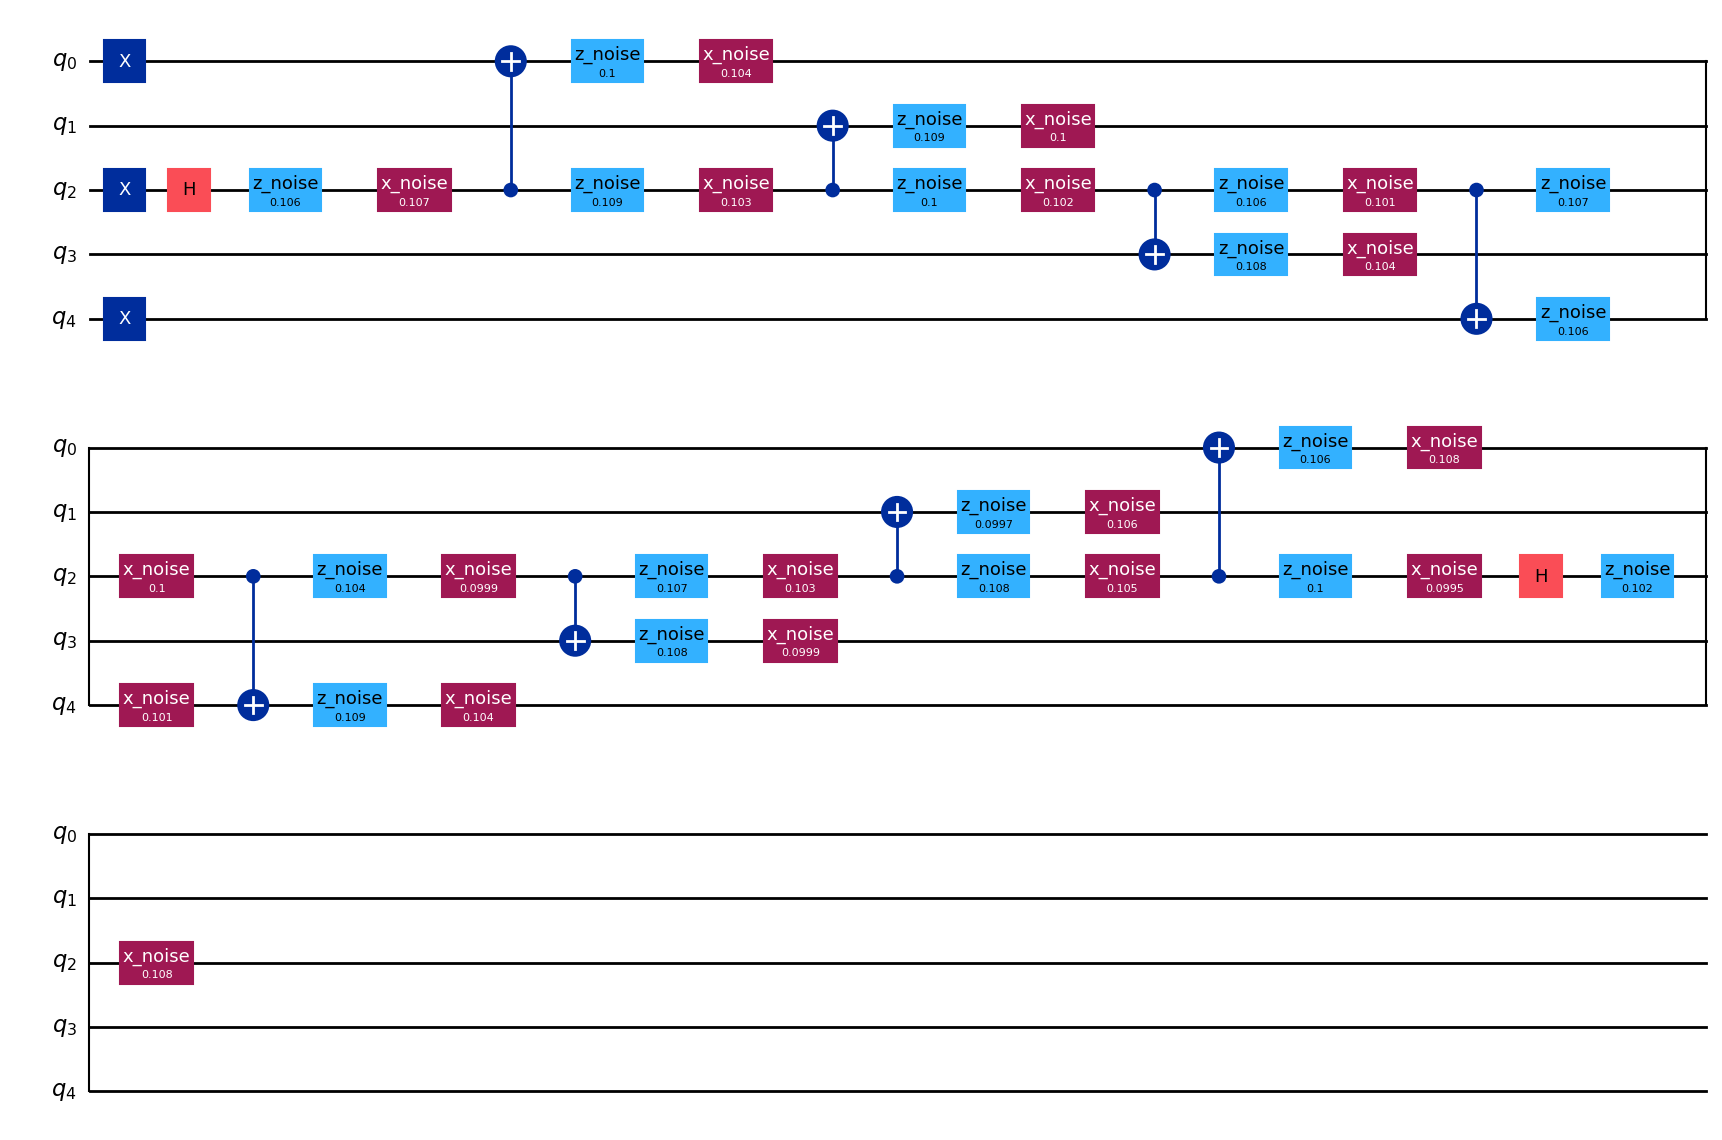

In [12]:
noisy_model_circ = ghz_circuit_gen.get_noisy_model_circuit_bitstring(INPUT_BITS)
noisy_model_circ.draw('mpl')

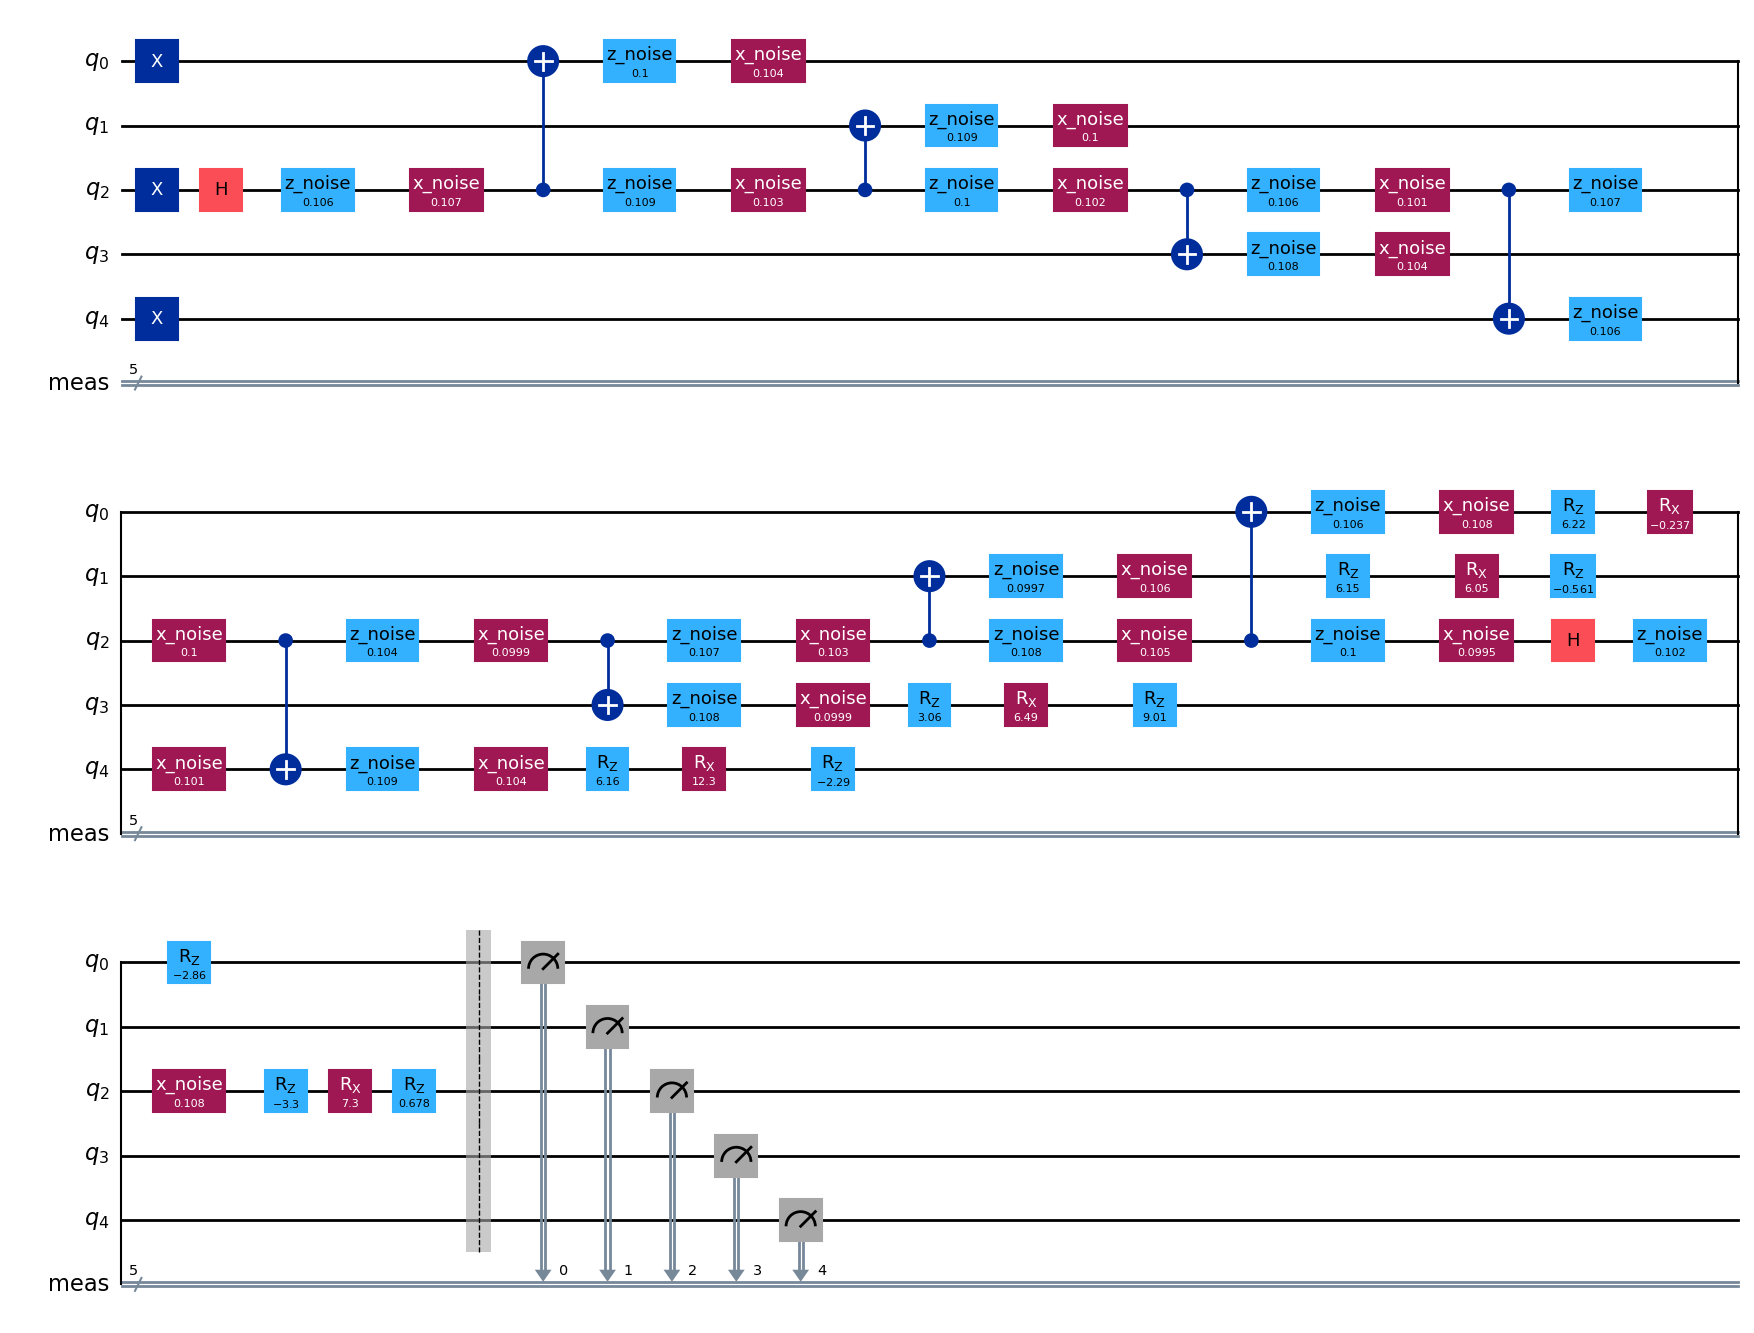

In [13]:
noisy_model_circ_pqc = append_pqc_to_quantum_circuit(noisy_model_circ, pqc_model.raw_params, qiskit_PQC_RZRXRZ_unique)
noisy_model_circ_pqc.draw('mpl')

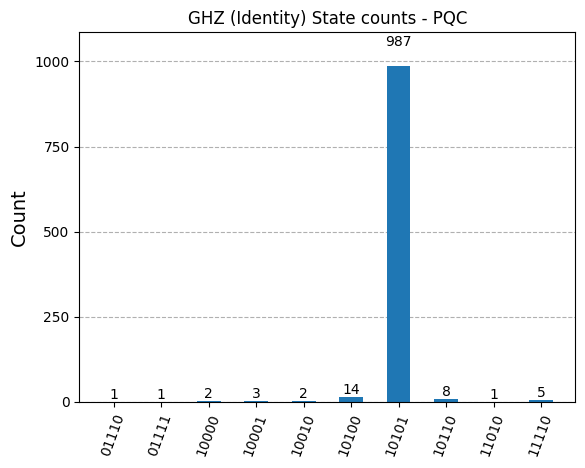

In [14]:
transpiled_circ = transpile(noisy_model_circ_pqc, ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - PQC')

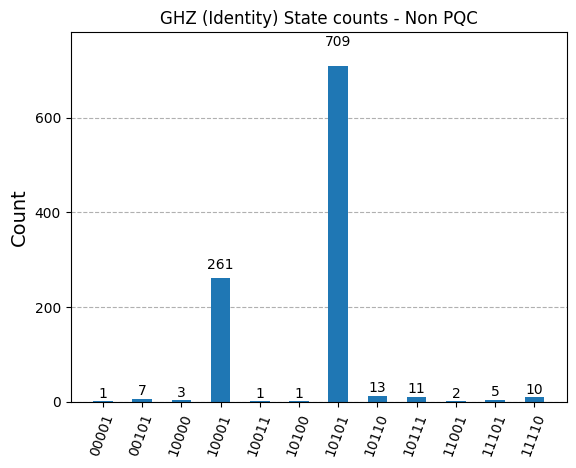

In [15]:
transpiled_circ = transpile(noisy_model_circ.measure_all(inplace=False), ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - Non PQC')

In [16]:
from simulator.simulate import run_circuit_sampler

def counts_to_probs(counts: torch.Tensor) -> torch.Tensor:
    """Convert integer counts to a normalized probability vector."""
    return counts.float() / counts.sum()

def fidelity(p, q):
    return torch.square(torch.sqrt(p * q).sum())

fid_noisy = []
fid_noisy_pqc = []

pqc_params = pqc_model.raw_params

ideal_data_test = get_ideal_data_superpos(NUM_QUBITS, NUM_SHOTS, num_vals=20)

for param, ideal in ideal_data_test:
    noisy_circ = ghz_circuit_gen.get_noisy_model_circuit_params(params=param)
    noisy_circ_pqc = append_pqc_to_quantum_circuit(noisy_circ, pqc_params, qiskit_PQC_RZRXRZ_unique)

    counts_noisy = run_circuit_sampler(noisy_circ.measure_all(inplace=False))
    counts_noisy_pqc = run_circuit_sampler(noisy_circ_pqc)

    prob_i = counts_to_probs(ideal)
    prob_n = counts_to_probs(counts_noisy)
    prob_ne = counts_to_probs(counts_noisy_pqc)

    fid_i_n = fidelity(prob_i, prob_n)
    fid_i_ne = fidelity(prob_i, prob_ne)

    fid_noisy.append(fid_i_n)
    fid_noisy_pqc.append(fid_i_ne)

    

Generating Ideal Data: 100%|██████████| 20/20 [00:00<00:00, 601.11it/s]


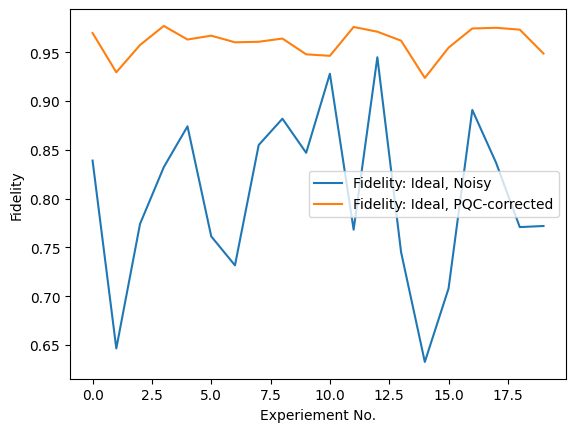

In [17]:
x = range(len(ideal_data_test))

# option 1 ─ two explicit calls
plt.plot(x, fid_noisy,      label='Fidelity: Ideal, Noisy')
plt.plot(x, fid_noisy_pqc,  label='Fidelity: Ideal, PQC-corrected')
plt.xlabel('Experiement No.')          # optional cosmetics
plt.ylabel('Fidelity')
plt.legend()                      # shows the two labels
plt.show()

In [18]:
print(f"Avg Fidelity of noisy circuit: {np.mean(fid_noisy)}, Average Fidelity of noisy circ with PQC: {np.mean(fid_noisy_pqc)}")

Avg Fidelity of noisy circuit: 0.8019167184829712, Average Fidelity of noisy circ with PQC: 0.9599544405937195


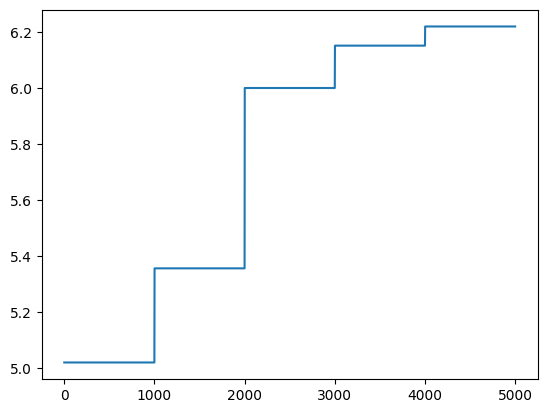

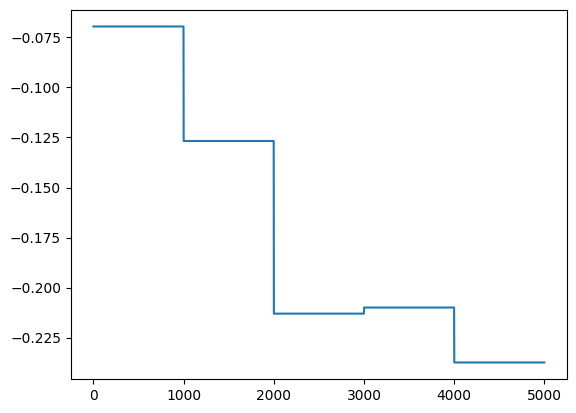

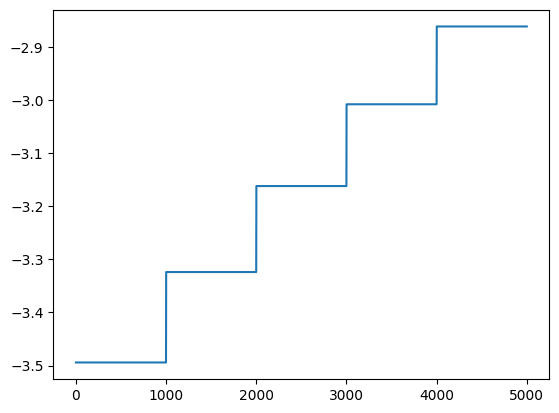

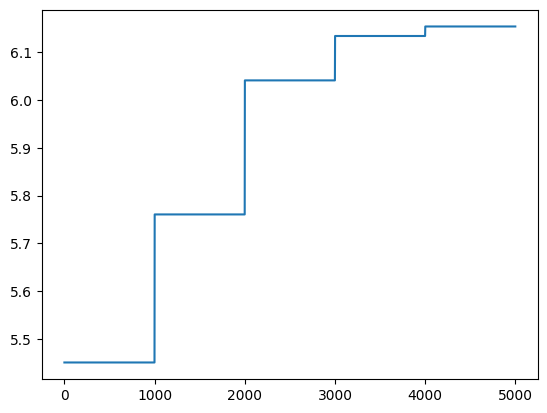

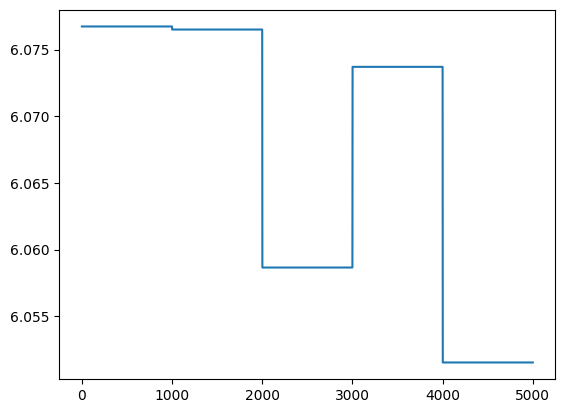

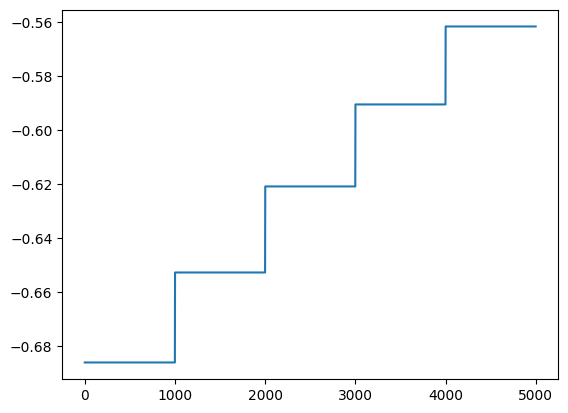

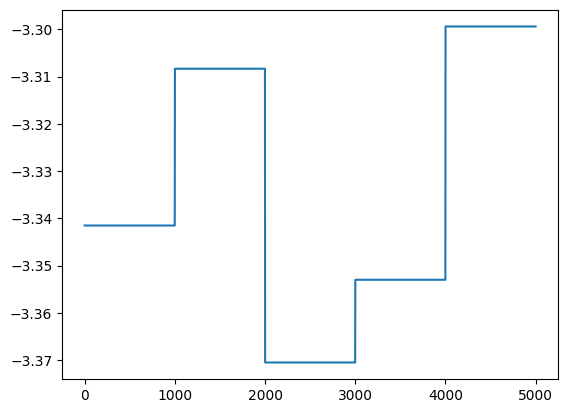

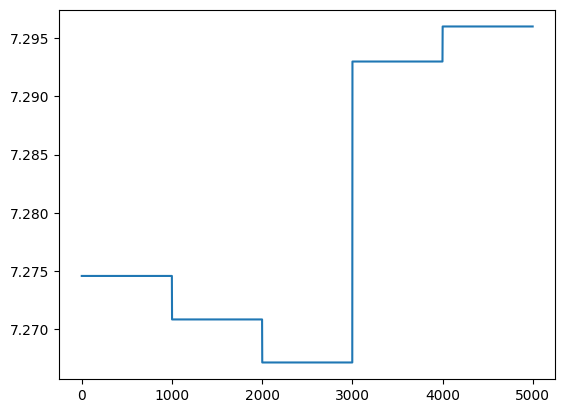

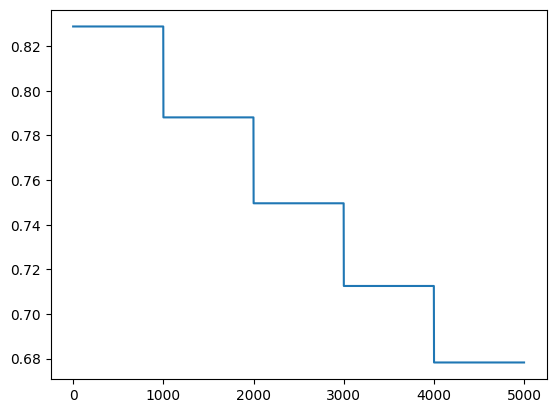

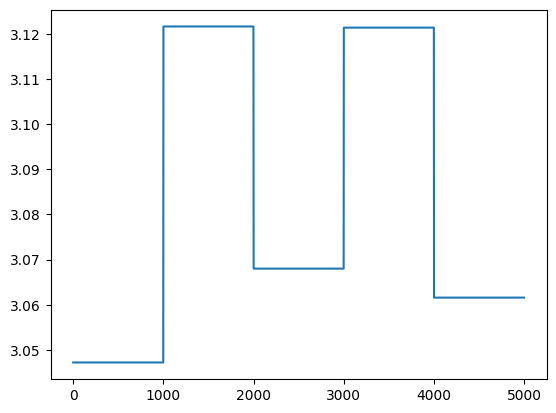

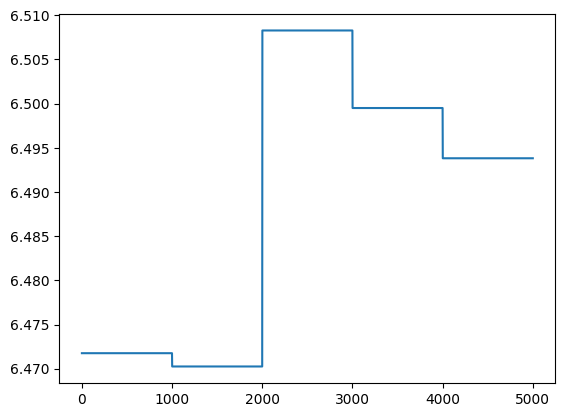

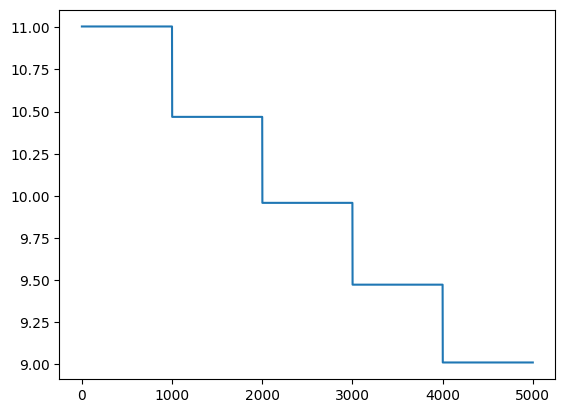

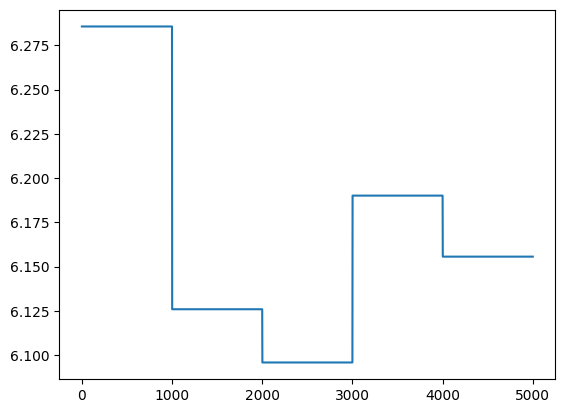

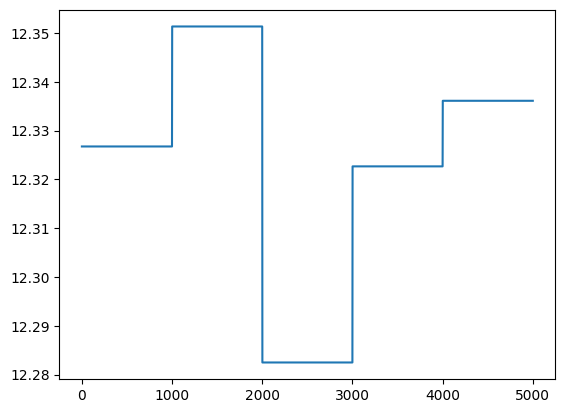

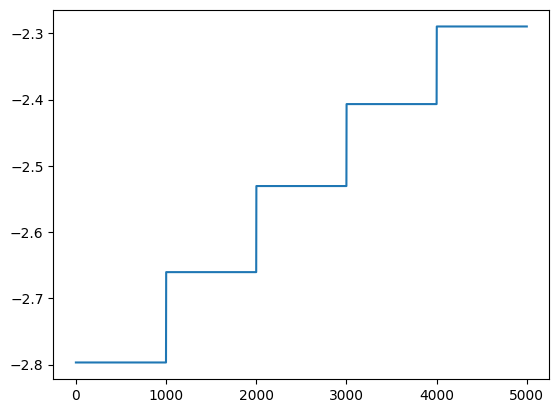

In [19]:
param_arr = np.array(param_list_epoch).transpose()
for pa in param_arr:
    plt.plot(range(len(pa)), pa)
    plt.show()